## Семинар 4: "Сверточные сети"

ФИО: Коновалов Михаил Анатольевич

In [60]:
import numpy as np
from sklearn.datasets import fetch_mldata
from sklearn.model_selection import train_test_split
import torch
from torch import nn
from torch.autograd import Variable
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision import transforms
from IPython.display import clear_output
%matplotlib inline

from skimage import io

### Часть 1: Свертка

#### Одномерные сигналы
Начнем с одномерных сигналов — например, это могут быть различные временные ряды. 

<i>1.1 Реализуйте функцию, вычисляющую одномерную свертку.</i>

In [17]:
def t_convolve(signal, kernel):
    signal_convolved = np.zeros(len(signal)-len(kernel)+1)
    # 1. не забудьте перевернуть ядро!
    # 2. необходимо реализовать свертку без отступов, т.е. 
    #   размер результирующего сигнала должен быть меньше входного.
    
    i = 0
    j = len(kernel)
    while j < len(signal) + 1:
        signal_convolved[i] = kernel.T[::-1] @ signal[i:j]
        i += 1
        j += 1
    
    return signal_convolved

Проверим правильность реализации, сравнив с реализацией из scipy

In [20]:
from scipy.signal import convolve

signal = np.random.rand(100)
kernel = np.random.rand(5)
t_result = t_convolve(signal, kernel)
b_result = convolve(signal, kernel, mode='valid')

np.testing.assert_allclose(t_result, b_result)

Посмотрим как операция свертки может помочь нам убрать шум из сигнала

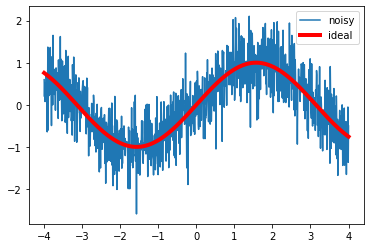

In [21]:
x = np.linspace(-4, 4, 1000)
signal = np.sin(x)
noisy_signal = signal + np.random.randn(signal.shape[0])*0.5
plt.plot(x, noisy_signal, label='noisy')
plt.plot(x, signal, 'r', label='ideal', linewidth=4)
plt.legend(loc=0)

Для подавления шума можно использовать усреднение значений сигнала в окрестности каждой точки (см. ЗБЧ). Вы можете убедиться, что такая операция может быть реализована при помощи свертки данных с ядром, $[\frac 1w, \frac 1w, ..., \frac 1w]$, где $w$ — размер окна.

<i>1.2  Вычислите свертку <b>зашумленного</b> сигнала с ядром $[0.2, 0.2, 0.2, 0.2, 0.2]$ </i>

In [29]:
kernel = np.array([.2] * 5)
denoised_signal = convolve(noisy_signal, kernel, 'same')

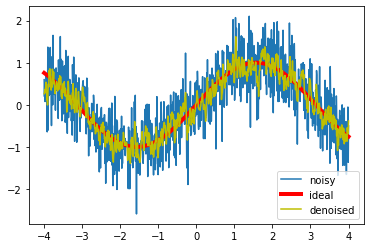

In [30]:
x = np.linspace(-4, 4, 1000)
plt.plot(x, noisy_signal, label='noisy')
plt.plot(x, signal, 'r', label='ideal', linewidth=4)
plt.plot(x, denoised_signal, 'y', label='denoised')
plt.legend(loc=0)

Заметим, что уровень шума значительно снизился! Попробуйте подобрать такую ширину окна, чтобы востановленный сигнал был наиболее похож на исходный.

<i> 1.3 Подберите размер окна <i>

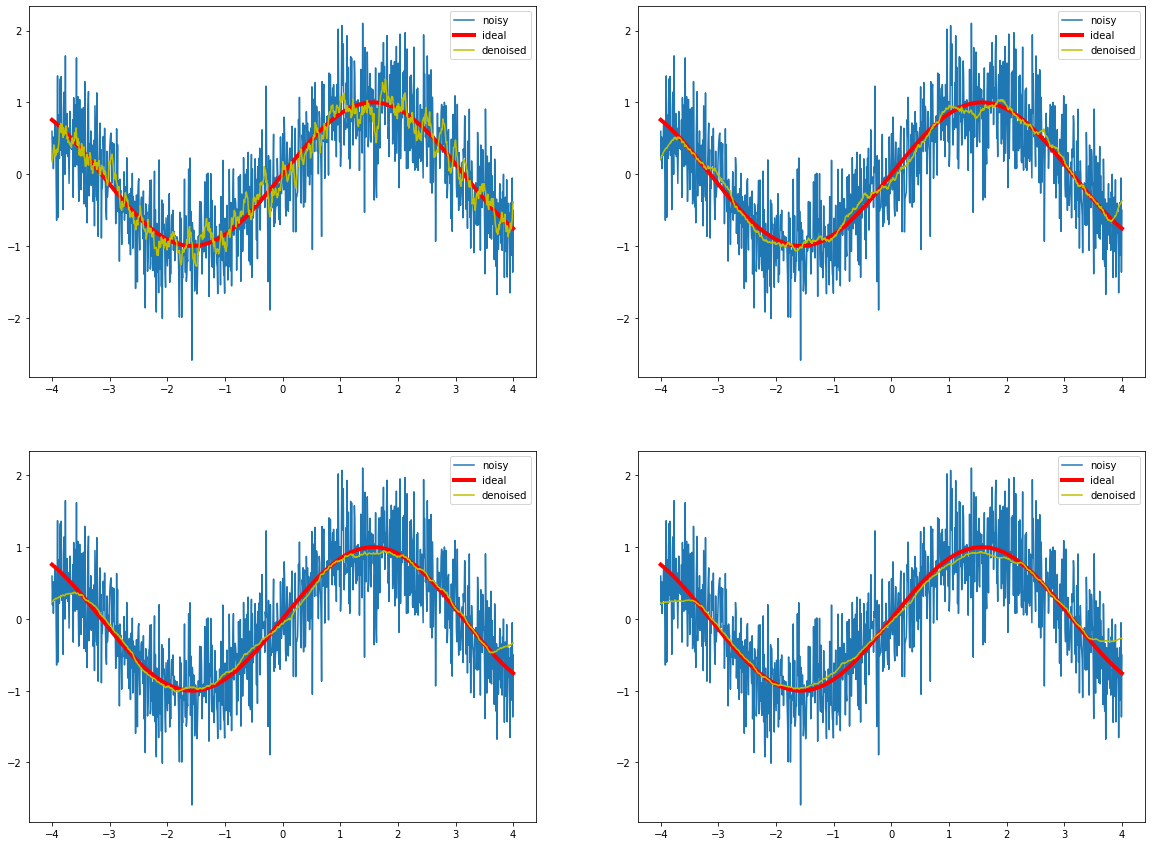

In [36]:
denoised_signals = []
for kernel_size in [10, 50, 100, 150]:
    kernel = np.array([1 / kernel_size] * kernel_size)
    denoised_signals.append(convolve(noisy_signal, kernel, "same"))
    
plt.figure(figsize=(20, 15))
for index, denoised_signal in enumerate(denoised_signals):
    ax = plt.subplot(220 + index + 1)
    ax.plot(x, noisy_signal, label="noisy")
    ax.plot(x, signal, 'r', label="ideal", linewidth=4)
    ax.plot(x, denoised_signal, 'y', label="denoised")
    plt.legend()

In [37]:
def mse(signal1, signal2):
    return ((signal1 - signal2) ** 2).mean()

for kernel_size in range(2, 150):
    kernel = np.array([1 / kernel_size] * kernel_size)
    denoised_signal = convolve(noisy_signal, kernel, "same")
    error = mse(signal, denoised_signal)
    print(kernel_size, error)

2 0.11491367936223287
3 0.07677867626545981
4 0.058651834733201694
5 0.047489718174182495
6 0.03966476303685103
7 0.03444506699049626
8 0.030871052922154148
9 0.027881831471555703
10 0.0259355732159005
11 0.02411110309302592
12 0.022749989218433932
13 0.021342240141361806
14 0.020166501363572793
15 0.018940186798752284
16 0.018082148710879615
17 0.017172819550152648
18 0.016528892339340965
19 0.015839816022655183
20 0.015365497149518154
21 0.014717126763827254
22 0.014287898570686283
23 0.013652327053781813
24 0.013293876736815967
25 0.012742348460403364
26 0.012486877018258437
27 0.01206843872722467
28 0.011934449479902381
29 0.0115136275634835
30 0.011380492804127909
31 0.011022785680589921
32 0.010940577801138685
33 0.010641034994620947
34 0.01058841539563975
35 0.010310813634039146
36 0.010290356026554264
37 0.010058645682004486
38 0.0100398334196168
39 0.009858659467242525
40 0.00987567864574039
41 0.009701135993991184
42 0.00972153304191626
43 0.009576665403316413
44 0.0095858497

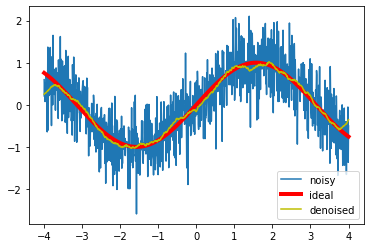

In [39]:
kernel = np.array([1 / 65] * 65)
denoised_signal = convolve(noisy_signal, kernel, 'same')

x = np.linspace(-4, 4, 1000)
plt.plot(x, noisy_signal, label='noisy')
plt.plot(x, signal, 'r', label='ideal', linewidth=4)
plt.plot(x, denoised_signal, 'y', label='denoised')
plt.legend(loc=0);

#### Многомерные сигналы
Перейдем теперь к черно-белым и цветным изображениям. Для ЧБ изображений имеем двумерный сигнал, для цветных — трехмерный (высота x ширина x каналы).

Для цветных изображений количество каналов ядра обычно совпадает с количеством каналов изображения. Таким образом, в результате получается черно-белое изображение.

<i>Для вычисления многомерных сверток используйте функцию convolve из from scipy.signal import convolve</i>

In [63]:
image = plt.imread("/Users/michelle/Downloads/my_image.jpg")

<i>1.4 Найдите в вашей любимой поисковой системе веса каналов для перевода цветного изображения в черно-белое. Постройте фильтр, который будет переводить цветное изображение в ЧБ</i>

In [64]:
color_to_bw = np.array([0.2989, 0.5870, 0.1140])

<i>1.5 На примере любого цветного изображения покажите результат его свертки с фильтром из предыдущего задания.</i>

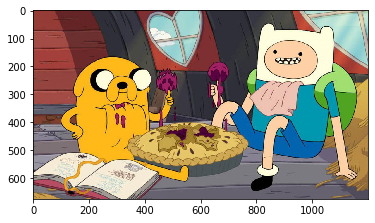

In [65]:
plt.imshow(image);

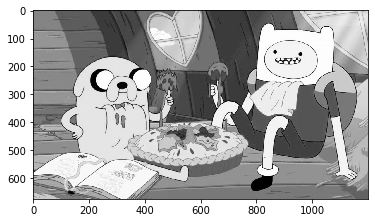

In [66]:
bw_image = convolve(image.flatten(), color_to_bw, "same")[::3].reshape(image.shape[0], image.shape[1])
# Не забудьте, что размер bw_image должен быть [w,h], а convolve вам вернет [w,h,1]
plt.imshow(bw_image, cmap=plt.cm.Greys_r)

Операция свертки также позволяет находить границы на изображении. Для этого можно использовать, например, фильтр Собеля.

<i>1.6 Задайте ядро <a href="https://ru.wikipedia.org/wiki/Оператор_Собеля">фильтра Собеля</a> и продемонстрируйте результат его применения к любому цветному изображению.</i>

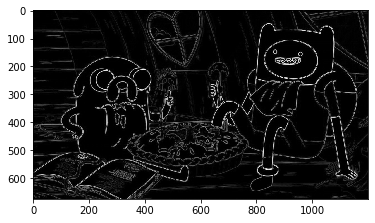

In [67]:
sobel = np.array([[-1, -2, -1],
                  [0, 0, 0],
                  [1, 2, 1]])

from scipy.signal import convolve2d

sobel_image_x = convolve2d(bw_image, sobel, "same")
sobel_image_y = convolve2d(bw_image, sobel.T, "same")
plt.imshow((sobel_image_x ** 2 + sobel_image_y ** 2) ** 0.5, cmap=plt.cm.Greys_r)

В сверточных нейронных сетях каждый слой использует несколько фильтров. Допустим, у нас было изображение с тремя каналами (количество входных каналов). Рассмотрим банк из четырех фильтров (количество выходных каналов). Тогда изначально будет вычислена свертка с каждым фильтром — получим 4 ЧБ изображения. Теперь соединим их в одно, интерпретируя каждое ЧБ изображение как канал цветного: RGB$\alpha$.

<i>1.7 Реализуйте операцию свертки с банком фильтров (filter bank).</i>

In [103]:
def t_convolve_bank(signal, kernel):
    assert signal.ndim == kernel.ndim - 1
    
    result = []
    for kernel_layer in range(kernel.shape[-1]):
        layer_result = np.zeros_like(signal[:, :, kernel_layer])
        for layer in range(signal.shape[-1]):
            layer_result += convolve2d(signal[:, :, layer], kernel[layer, :, :, kernel_layer], "same")
        result.append(layer_result)
        
    return np.array(result).transpose((1, 2, 0))

<i>1.8 Задайте банк фильтров, меняющий порядок следования каналов с RGB на BGR.</i>

In [144]:
kernels = np.array([
    [0, 0, 1],
    [0, 1, 0],
    [1, 0, 0]]).reshape(3, 1, 1, 3)

<i>1.9 Продемонстрируйте результат свертки любого цветного изображения с банком фильтров из предыдущего пункта.</i>

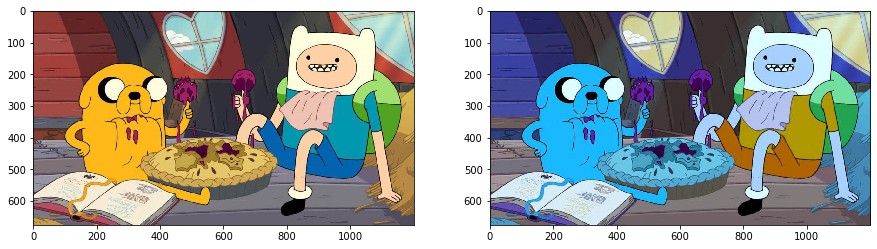

In [146]:
plt.figure(figsize=(15, 10))
shuffled_image = t_convolve_bank(image.astype("float"), kernels)
ax = plt.subplot(221)
ax.imshow(image)
ax1 = plt.subplot(222)
ax1.imshow(shuffled_image.reshape(675, 1200, 3).astype("uint8"))
# Не забудьте, что после свертки вы скорее всего получите тензор типа float. 
# Чтобы imshow нормально отобразил результат, надо привести его к типу uint8 (нпр., при помощи .astype('uint8'))

В процессе обучения сверточных нейронных сетей настраиваются веса элементов фильтр банка. Это позволяет не заниматься подбором коэффициентов "руками", а задавать лишь размер ядра: ширину, высоту, количество входных и выходных каналов. В итоге получаем четырехмерный массив (тензор).

### Часть 2: Пулинг

При использовании сверточных слоев принято использовать слои пулинга. Эта операция позволяет уменьшить пространственные размерности изображения и избавиться от избыточности.

<i>2.1 Реализуйте операции пулинга для цветных изображений</i>

In [309]:
def pool(image, func, w=2):
    assert(image.ndim == 3)
    
    result = np.zeros((image.shape[0] // w, image.shape[1] // w, image.shape[2]))
    
    for i in range(result.shape[0]):
        for j in range(result.shape[1]):
            result[i, j, :] = func(image[i * w:(i + 1) * w, j * w:(j + 1) * w]
                                     .reshape(-1, image.shape[2]), axis=0)
    
    return result.astype("uint8")


def maxpool(image, w=2):
    return pool(image, np.max, w)


def medianpool(image, w=2):
    return pool(image, np.median, w)

Как и в первой части, посмотрим сначала как эта опреация влияет на цветные изображения.

<i>2.2 Взять цветное изображение и добавить к нему <a href="https://ru.wikipedia.org/wiki/Salt_and_pepper"> шум соль и перец</a>. Применить медианный пулинг и максимальный пулинг.</i>

Text(0.5, 1.0, 'Medianpool')

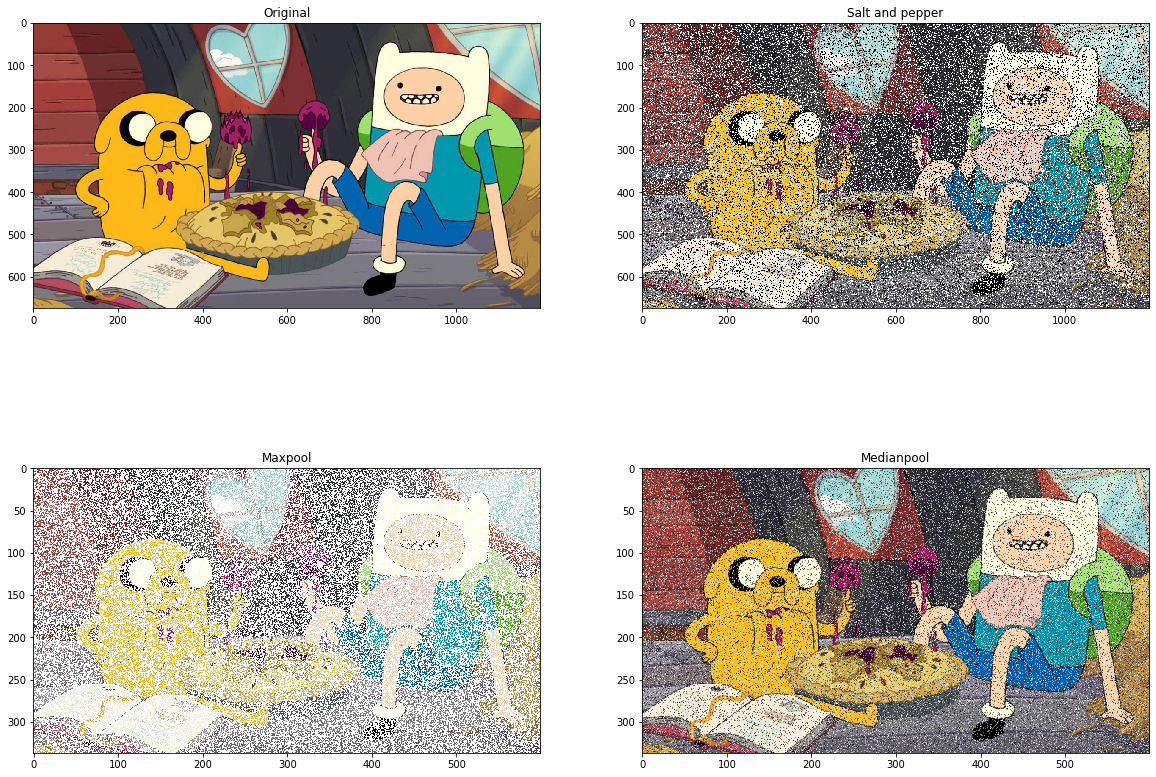

In [314]:
zeros_indices = np.random.rand(image.shape[0], image.shape[1]) > 0.8
ones_indices = np.random.rand(image.shape[0], image.shape[1]) > 0.8

salt_pepper_image = image.copy()
salt_pepper_image[zeros_indices, :] = 0
salt_pepper_image[ones_indices, :] = 255

plt.figure(figsize=(20, 15))

ax1 = plt.subplot(221)
ax1.imshow(image)
ax1.set_title("Original")

ax2 = plt.subplot(222)
ax2.imshow(salt_pepper_image)
ax2.set_title("Salt and pepper")

ax3 = plt.subplot(223)
ax3.imshow(maxpool(salt_pepper_image))
ax3.set_title("Maxpool")

ax4 = plt.subplot(224)
ax4.imshow(medianpool(salt_pepper_image))
ax4.set_title("Medianpool")

<i>2.3 Какой тип пулинга лучше справился с поставленной задачей? Почему?</i>

Лучше справился медианный пулинг, что можно объяснить выбором в каждом квадрате 2х2 пикселя с медианной интенсивностью, при этом выше вероятность, что это будет реальный пиксель картинки, а не шум. Макспулинг же выбирает пиксель с максимальным значением, и если в квадрате попадется шумовой белый пиксель (с 255 по всем каналам), то он выберет его.

### Часть 3: Сверточная сеть на pyTorch

pyTorch предоставляет модули свертки и пулинга. Попробуем построить сеть и натренировать ее на данных MNIST. Для загрузки данных воспользуйтесь кодом со второго семинара.

Воспользуемся кодом с предыдущего семинара, чтобы обучить сверточную сеть на данных MNIST. Попробуем две архитектуры: 
1. input -> 8 Conv 3x3 -> ReLU -> maxpool -> 16 Conv 3x3 -> ReLU -> ravel -> Linear -> LogSoftmax
2. input -> 8 Conv 3x3 -> ReLU -> 16 Conv 3x3 -> ReLU -> maxpool -> 32 Conv 3x3 -> ravel -> Linear -> LogSoftmax

Здесь запись "c conv KxK" означает то, что на выходе должно получиться c каналов, а размер ядра — KxK

Ниже приведен пример сети. <i>(Документация: http://pytorch.org/docs/)</i>

In [244]:
transform = transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                    ])
train_dataset = MNIST('.', train=True, download=True, transform=transform)
test_dataset = MNIST('.', train=False, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw
Using downloaded and verified file: ./MNIST/raw/train-labels-idx1-ubyte.gz
Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw
Using downloaded and verified file: ./MNIST/raw/t10k-images-idx3-ubyte.gz
Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw
Using downloaded and verified file: ./MNIST/raw/t10k-labels-idx1-ubyte.gz
Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw
Processing...
Done!


In [239]:
# пример сверточной сети

image_size = 28
channels = 1
class ConvClassifier(nn.Module):
    def __init__(self, image_size):
        super(ConvClassifier, self).__init__()
        self.conv_layers = nn.Sequential(nn.Conv2d(channels, 3, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2))
        self.linear_layers = nn.Sequential(nn.Linear(image_size // 2 * image_size // 2 * 3, 10),
                                           nn.LogSoftmax(dim=1))
    
    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        x = self.linear_layers(x)
        return x

In [240]:
def train(network, epochs, learning_rate):
    loss = nn.NLLLoss()
    optimizer = torch.optim.Adam(network.parameters(), lr=learning_rate)
    train_loss_epochs = []
    test_loss_epochs = []
    train_accuracy_epochs = []
    test_accuracy_epochs = []
    try:
        for epoch in range(epochs):
            losses = []
            accuracies = []
            for X, y in train_loader:
                network.zero_grad()
                prediction = network(X)
                loss_batch = loss(prediction, y)
                losses.append(loss_batch.item())
                loss_batch.backward()
                optimizer.step()
                accuracies.append((np.argmax(prediction.data.numpy(), 1)==y.data.numpy()).mean())
            train_loss_epochs.append(np.mean(losses))
            train_accuracy_epochs.append(np.mean(accuracies))
            losses = []
            accuracies = []    
            for X, y in test_loader:
                prediction = network(X)
                loss_batch = loss(prediction, y)
                losses.append(loss_batch.item())
                accuracies.append((np.argmax(prediction.data.numpy(), 1)==y.data.numpy()).mean())
            test_loss_epochs.append(np.mean(losses))
            test_accuracy_epochs.append(np.mean(accuracies))
            clear_output(True)
            print('\rEpoch {0}... (Train/Test) NLL: {1:.3f}/{2:.3f}\tAccuracy: {3:.3f}/{4:.3f}'.format(
                        epoch, train_loss_epochs[-1], test_loss_epochs[-1],
                        train_accuracy_epochs[-1], test_accuracy_epochs[-1]))
            plt.figure(figsize=(12, 5))
            plt.subplot(1, 2, 1)
            plt.plot(train_loss_epochs, label='Train')
            plt.plot(test_loss_epochs, label='Test')
            plt.xlabel('Epochs', fontsize=16)
            plt.ylabel('Loss', fontsize=16)
            plt.legend(loc=0, fontsize=16)
            plt.grid()
            plt.subplot(1, 2, 2)
            plt.plot(train_accuracy_epochs, label='Train accuracy')
            plt.plot(test_accuracy_epochs, label='Test accuracy')
            plt.xlabel('Epochs', fontsize=16)
            plt.ylabel('Loss', fontsize=16)
            plt.legend(loc=0, fontsize=16)
            plt.grid()
            plt.show()
    except KeyboardInterrupt:
        pass

Epoch 9... (Train/Test) NLL: 0.052/0.052	Accuracy: 0.985/0.984


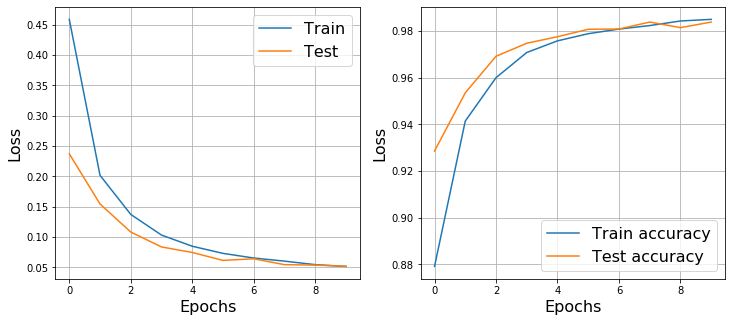

In [281]:
network = ConvClassifier(image_size=28)
train(network, 10, 1e-4)

<i>3.1 Обучите сверточные сети с архитектурами (1) и (2). Какое качество удалось получить на тестовой выборке? Какой результат получался на полносвязной нейронной сети?</i>

1. input -> 8 Conv 3x3 -> ReLU -> maxpool -> 16 Conv 3x3 -> ReLU -> ravel -> Linear -> LogSoftmax

In [282]:
image_size = 28
channels = 1
class ConvClassifier(nn.Module):
    def __init__(self, image_size):
        super(ConvClassifier, self).__init__()
        self.conv_layers = nn.Sequential(nn.Conv2d(channels, 8, (3, 3), padding=1),nn.ReLU(), nn.MaxPool2d(2),
                                         nn.Conv2d(8, 16, (3, 3), padding=1),nn.ReLU())
        self.linear_layers = nn.Sequential(nn.Linear(image_size // 2 * image_size // 2 * 16, 10),
                                           nn.LogSoftmax(dim=1))
    
    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        x = self.linear_layers(x)
        return x

Epoch 9... (Train/Test) NLL: 0.051/0.053	Accuracy: 0.985/0.983


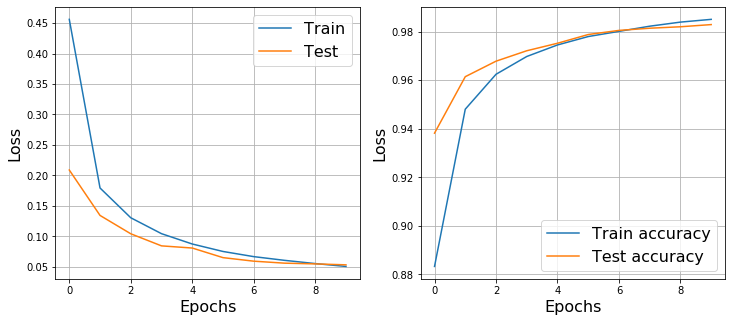

In [283]:
network = ConvClassifier(image_size=28)
train(network, 10, 1e-4)

2. input -> 8 Conv 3x3 -> ReLU -> 16 Conv 3x3 -> ReLU -> maxpool -> 32 Conv 3x3 -> ravel -> Linear -> LogSoftmax

Epoch 9... (Train/Test) NLL: 0.042/0.041	Accuracy: 0.987/0.987


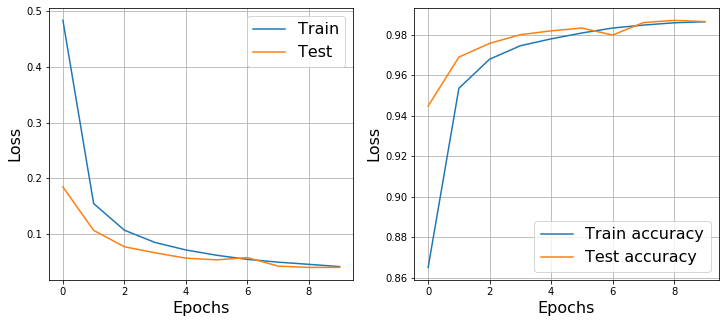

In [306]:
image_size = 28
channels = 1
class ConvClassifier(nn.Module):
    def __init__(self, image_size):
        super(ConvClassifier, self).__init__()
        self.conv_layers = nn.Sequential(nn.Conv2d(channels, 8, (3, 3), padding=1),nn.ReLU(), nn.MaxPool2d(2),
                                         nn.Conv2d(8, 16, (3, 3), padding=1),nn.ReLU(), nn.MaxPool2d(2),
                                         nn.Conv2d(16, 32, (3, 3), padding=1), nn.ReLU())
        self.linear_layers = nn.Sequential(nn.Linear(image_size // 4 * image_size // 4 * 32, 10),
                                           nn.LogSoftmax(dim=1))
    
    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        x = self.linear_layers(x)
        return x
    
    
network = ConvClassifier(image_size=28)
train(network, 10, 1e-4)

Удалось достигнуть точность 0.987 на тестовой выборке. На линейной сети было 0.975 (без аугментраций).

<i>3.2 На каких объектах сеть ошибается сильнее всего? Нарисуйте эти объекты с правильными и предсказаными метками.</i>

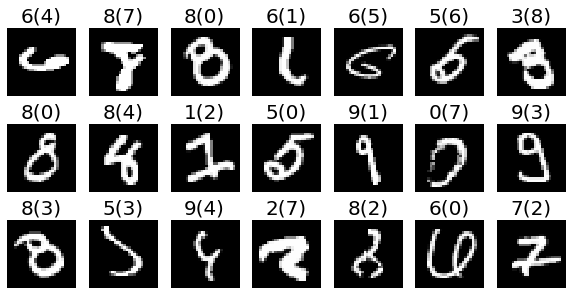

In [280]:
wrong_X = []
correct_y = []
predicted_y = []
logits = []

for X, y in test_loader:
    prediction = network(X)
#     prediction = np.exp(prediction)
#     prediction /= prediction.sum(1, keepdims=True)
    for i, _ in enumerate(prediction.detach().numpy()):
        if np.argmax(prediction[i].detach().numpy()) != y[i].detach().numpy():
            wrong_X.append(X[i].detach().numpy())
            correct_y.append(y[i].detach().numpy())
            predicted_y.append(np.argmax(prediction[i].detach().numpy()))
            logits.append(prediction[i][y[i]].detach().numpy())

wrong_X = np.row_stack(wrong_X)
correct_y = np.row_stack(correct_y)[:, 0]
predicted_y = np.row_stack(predicted_y)[:, 0]
logits = np.row_stack(logits)[:, 0]

plt.figure(figsize=(10, 5))
order = np.argsort(logits)

for i in range(21):
    plt.subplot(3, 7, i + 1)
    plt.imshow(wrong_X[order[i]].reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.title('{}({})'.format(correct_y[order[i]], predicted_y[order[i]]), fontsize=20)
    plt.axis('off')

<i>3.3 Поэкспериментируйте с различными архитектурами сверточных сетей. Смогли ли вы улучшить результат на тестовой выборке?</i>

Epoch 9... (Train/Test) NLL: 0.023/0.026	Accuracy: 0.993/0.991


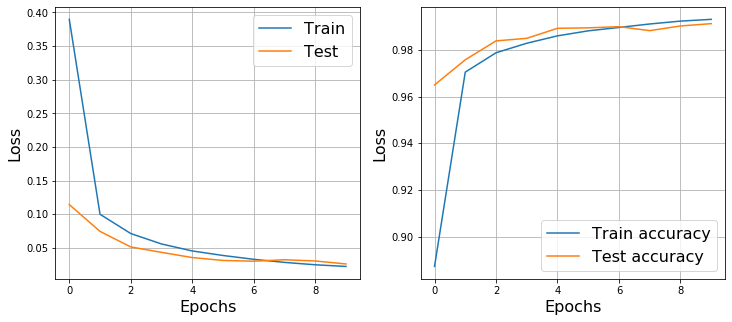

In [305]:
image_size = 28
channels = 1
class ConvClassifier(nn.Module):
    def __init__(self, image_size):
        super(ConvClassifier, self).__init__()
        self.conv_layers = nn.Sequential(nn.Conv2d(channels, 16, (3, 3), padding=1), nn.ReLU(), nn.MaxPool2d(2),
                                         nn.Conv2d(16, 32, (3, 3), padding=1), nn.ReLU(), nn.MaxPool2d(2),
                                         nn.Conv2d(32, 64, (3, 3), padding=1), nn.ReLU(), nn.MaxPool2d(2),
                                         nn.Conv2d(64, 128, (3, 3), padding=1), nn.ReLU())
        self.linear_layers = nn.Sequential(nn.Linear(1152, 10),
                                           nn.LogSoftmax(dim=1))
    
    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        x = self.linear_layers(x)
        return x
    
    
network = ConvClassifier(image_size=28)
train(network, 10, 1e-4)

Удаллсь немного повысить результат (до 0.991 на тесте).

#### Feedback (опционально)

Здесь вы можете оставить список опечаток из лекции или семинара:

Здесь вы можете оставить комментарии по лекции или семинару: